In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.models import vit_b_16
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [9]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Runing on {str(device)}")

# Define dataset paths
torch_train_path = "./animals90TrainDataset.pt"
torch_test_path = "./animals90TestDataset.pt"
torch_val_path = "./animals90ValDataset.pt"

# Define class names
class_names =  [
    "antelope", "badger", "bat", "bear", "bee", "beetle", "bison", "boar", "butterfly",
    "cat", "caterpillar", "chimpanzee", "cockroach", "cow", "coyote", "crab", "crow",
    "deer", "dog", "dolphin", "donkey", "dragonfly", "duck", "eagle", "elephant",
    "flamingo", "fly", "fox", "goat", "goldfish", "goose", "gorilla", "grasshopper",
    "hamster", "hare", "hedgehog", "hippopotamus", "hornbill", "horse", "hummingbird",
    "hyena", "jellyfish", "kangaroo", "koala", "ladybugs", "leopard", "lion", "lizard",
    "lobster", "mosquito", "moth", "mouse", "octopus", "okapi", "orangutan", "otter",
    "owl", "ox", "oyster", "panda", "parrot", "pelecaniformes", "penguin", "pig",
    "pigeon", "porcupine", "possum", "raccoon", "rat", "reindeer", "rhinoceros",
    "sandpiper", "seahorse", "seal", "shark", "sheep", "snake", "sparrow", "squid",
    "squirrel", "starfish", "swan", "tiger", "turkey", "turtle", "whale", "wolf",
    "wombat", "woodpecker", "zebra"
]
class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
num_classes = len(class_names)

# Load dataset from Torch tensor file
print("Loading dataset from Torch tensor file...")
train_data = torch.load(torch_train_path)
print("Dataset loaded successfully.")
test_data = torch.load(torch_test_path)
print("Test dataset loaded successfully.")
val_dataset = torch.load(torch_val_path)
print("Validation dataset loaded successfully.")
train_images, train_labels = train_data["images"], train_data["labels"]
test_images, test_labels = test_data["images"], test_data["labels"]
val_images, val_labels = val_dataset["images"], val_dataset["labels"]

train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)
val_dataset = TensorDataset(val_images, val_labels)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

Runing on cpu
Loading dataset from Torch tensor file...
Dataset loaded successfully.
Test dataset loaded successfully.
Validation dataset loaded successfully.
Train samples: 4320, Val samples: 1080, Test samples: 100


In [3]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
# Load pre-trained ViT model and modify classifier
model = vit_b_16(pretrained=True)
num_features = model.heads.head.in_features
model.heads.head = nn.Linear(num_features, len(class_names))
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)

epochs = 10  # Increase as needed

c:\Users\Hizan\softwares\anaconda3\envs\ece1508\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hizan\softwares\anaconda3\envs\ece1508\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def plot_loss_and_accuracy(train_losses, val_losses, train_accs, val_accs):
    """
    Plots the training/validation loss and accuracy curves in separate charts.
    """
    # Plot loss
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.show()

    # Plot accuracy
    plt.figure()
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.show()

In [6]:
train_losses = []
train_accs   = []
val_losses   = []
val_accs     = []

for epoch in range(epochs):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images_batch, labels_batch in train_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        
        # Track training loss
        running_loss += loss.item() * images_batch.size(0)
        
        # Compute training accuracy
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels_batch).sum().item()
        total += labels_batch.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

    # --- Validation ---
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images_batch, labels_batch in val_loader:
            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)

            outputs = model(images_batch)
            loss = criterion(outputs, labels_batch)
            
            # Track validation loss
            val_running_loss += loss.item() * images_batch.size(0)
            # Compute validation accuracy
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(labels_batch).sum().item()
            val_total += labels_batch.size(0)
    
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_epoch_acc = val_correct / val_total
    
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
    print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}\n")


c:\Users\Hizan\softwares\anaconda3\envs\ece1508\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [1/10] - Train Loss: 2.8434, Train Acc: 0.5572
Val Loss: 1.2023, Val Acc: 0.8620

Epoch [2/10] - Train Loss: 0.5874, Train Acc: 0.9495
Val Loss: 0.5453, Val Acc: 0.9194

Epoch [3/10] - Train Loss: 0.1754, Train Acc: 0.9907
Val Loss: 0.3753, Val Acc: 0.9389

Epoch [4/10] - Train Loss: 0.0716, Train Acc: 0.9984
Val Loss: 0.3278, Val Acc: 0.9398

Epoch [5/10] - Train Loss: 0.0387, Train Acc: 0.9995
Val Loss: 0.3027, Val Acc: 0.9435

Epoch [6/10] - Train Loss: 0.0280, Train Acc: 0.9993
Val Loss: 0.2994, Val Acc: 0.9333

Epoch [7/10] - Train Loss: 0.0198, Train Acc: 0.9998
Val Loss: 0.2990, Val Acc: 0.9296

Epoch [8/10] - Train Loss: 0.0158, Train Acc: 0.9995
Val Loss: 0.2791, Val Acc: 0.9352

Epoch [9/10] - Train Loss: 0.0127, Train Acc: 0.9998
Val Loss: 0.2890, Val Acc: 0.9333

Epoch [10/10] - Train Loss: 0.0105, Train Acc: 0.9995
Val Loss: 0.2799, Val Acc: 0.9352



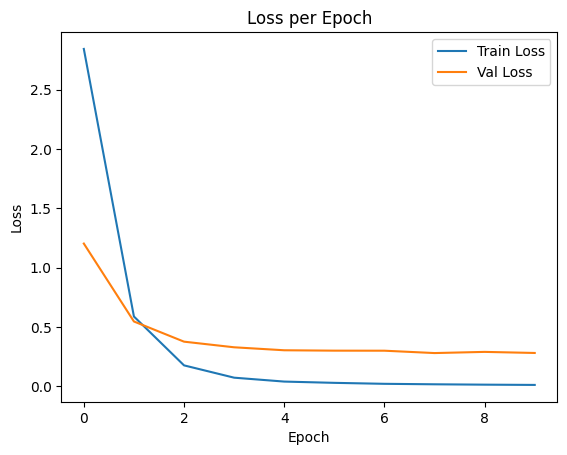

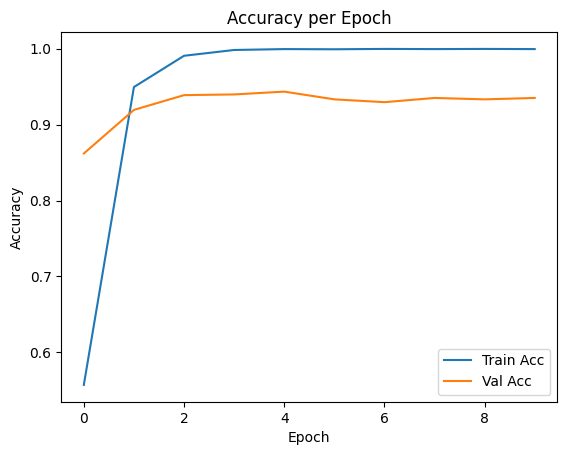

In [7]:
# Plot Loss and Accuracy
plot_loss_and_accuracy(train_losses, val_losses, train_accs, val_accs)

In [8]:

# Testing
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for images_batch, labels_batch in test_loader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        
        test_loss += loss.item() * images_batch.size(0)
        _, predicted = outputs.max(1)
        test_correct += predicted.eq(labels_batch).sum().item()
        test_total += labels_batch.size(0)

test_loss /= len(test_loader.dataset)
test_acc = test_correct / test_total
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Test Loss: 0.1659, Test Acc: 0.9900
